In [16]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, concatenate, Conv2D, MaxPooling2D

In [9]:
class DQN(tf.keras.Model):
    def __init__(self, state_size, current_size, mask_size, furniture_size, next_size):
        super(DQN, self).__init__()
        
        self.grid_cnn = Conv2D(filters=5, kernel_size=3, activation='relu', padding='valid', input_shape=state_size)
        self.grid_dnn = Dense(32, activation='relu')
        
        self.cur_grid_cnn = Conv2D(filters=5, kernel_size=3, activation='relu', padding='valid', input_shape=current_size)
        self.cur_grid_dnn = Dense(32, activation='relu')
        
        self.mask_grid_cnn = Conv2D(filters=5, kernel_size=3, activation='relu', padding='valid', input_shape=mask_size)
        self.mask_grid_dnn = Dense(32, activation='relu')
        
        self.size_grid_cnn = Conv2D(filters=5, kernel_size=3, activation='relu', padding='valid', input_shape=furniture_size)
        self.size_grid_dnn = Dense(32, activation='relu')
        
        self.next_grid_cnn = Conv2D(filters=5, kernel_size=3, activation='relu', padding='valid', input_shape=next_size)
        self.next_grid_dnn = Dense(32, activation='relu')
        
        self.f1 = Dense(256, activation='relu')
        self.f2 = Dense(128, activation='relu')
        self.f = Dense(1)
        
    def call(self, datas):
        grid, cur_grid, mask_grid, size_grid, next_grid = datas[0], datas[1], datas[2], datas[3], datas[4]
        
        g = self.grid_cnn(g)
        g = MaxPooling2D(pool_size=(2,2))(g)
        g = Flatten()(g)
        g = self.grid_dnn(g)
        
        c = self.cur_grid_cnn(c)
        c = MaxPooling2D(pool_size=(2,2))(c)
        c = Flatten()(c)
        c = self.cur_grid_dnn(c)
        
        m = self.mask_grid_cnn(m)
        m = MaxPooling2D(pool_size=(2,2))(m)
        m = Flatten()(m)
        m = self.mask_grid_dnn(m)
        
        s = self.size_grid_cnn(s)
        s = MaxPooling2D(ppol_size=(2,2))(s)
        s = Flatten()(s)
        s = self.size_grid_dnn(s)
        
        n = self.next_grid_cnn(n)
        n = MaxPooling2D(pool_size=(2,2))(n)
        n = Flatten()(n)
        n = self.next_grid_dnn(n)
        
        x = concatenate([g,c,m,s,n])     
        x = self.f1(x)
        x = self.f2(x)
        q = self.f(x)
        
        return q

In [10]:
import random
from collections import deque

In [14]:
class Agent:
    def __init__(self, L=30, B=30, learning_rate=1e-8, exp_steps=500, train_st=200, batch_size=32, memory_len=500, 
                update_target_rate=30):
        self.state_size = (L,B)
        self.current_size = (L,B)
        self.mask_size = (L,B)
        self.furniture_size = (L,B)
        self.next_size = (L,B)
        
        self.discount_factor = 0.99
        self.learning_rate = learning_rate
        self.epsilon = 1.
        self.epsilon_start, self.epsilon_end = 1.0, 0.01
        self.exploration_steps = exp_steps
        self.epsilon_decay_step = self.epsilon_start - self.epsilon_end
        self.epsilon_decay_step /= self.exploration_steps
        self.batch_size = batch_size
        self.train_start = train_st
        self.update_target_rate = update_target_rate
        
        self.memory = deque(maxlen=memory_len)
        self.gamma = 0.9
    
        self.model = DQN(self.state_size, self.current_size, self.mask_size, self.furniture_size, self.next_size)
        self.target_model = DQN(self.state_size, self.current_size, self.mask_size, self.furniture_size, self.next_size)
        
        self.optimizer = Adam(self.learning_rate)
        self.update_target_model()
        self.avg_q_max, self.avg_loss = 0,0
        self.model_path = os.path.join(os.getcwd(), 'save_mode', 'model_3d')
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
        
    def get_action(self, state, current, mask, f_size):
        if np.random.rand() < self.epsilon:
            random_action = random.randrange(len(state))
            return random_action
        else:
            q_values = self.model([state, current, mask, f_size])
            argmax_idx = np.where(q_values == tf.math.reduce_max(q_values))
            action_idx = argmax_idx[0][0]
            return action_idx
        
    def append_sample(self, history, current, mask, f_size, next_state, reward, last, 
                      t_history, t_current, t_mask, t_f_size, t_next_state):
        self.memory.append((history, current, mask, f_size, next_state, reward, last, 
                            t_history, t_current, t_mask, t_f_size, t_next_state))
        
    def train_model(self):
        batch = random.sample(self.memory, self.batch_size)
        
        history = np.array([sample[0] for sample in batch])
        current = np.array([sample[1] for sample in batch])
        mask = np.array([sample[2] for sample in batch])
        f_size = np.array([sample[3] for sample in batch])
        next_staet = np.array([sample[4] for sample in batch])
        reward = np.array([sample[5] for sample in batch])
        last = np.array([sample[6] for sample in batch])
        t_history = np.array([sample[7] for sample in batch])
        t_current = np.array([sample[8] for sample in batch])
        t_mask = np.array([sample[9] for sample in batch])
        t_f_size = np.array([sample[10] for sample in batch])
        t_next_state = np.array([sample[11] for sample in batch])
        
        model_params = self.model.trainable_variables
        with tf.GradientTape() as tape:
            pred = self.model([history, current, mask, f_size, next_state])
            targets = []
            for i in range(self.batch_size):
                t_q = self.target_model([t_history[i], t_current[i], t_mask[i], t_f_size[i], t_next_state[i]])
                t_max_q = tf.math.reduce_max(t_q)
                targets.append([(1-0.75)*reward[i] + (1-last[i])*0.75*t_max_q])
            targets = np.array(targets)
            error = tf.abs(targets-predicts)
            quadratic_part = tf.clip_by_value(error, 0.0, 1.0)
            linear_part = error-quadratic_part
            loss = tf.reduce_mean(0.5 * tf.square(quadratic_part) + linear_part)
            self.avg_loss += loss.numpy()
        
        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))
        

In [2]:
import time
import json

## 데이터 로드

In [3]:
with open('data/ikea.json', 'r') as ikea_json:
    ikea_python = json.load(ikea_json)
ikea = json.loads(ikea_python)
ikea

[[{'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''}],
 [{'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'type': ''},
  {'value': 0, 'typ

In [4]:
arr = []
for i in range(20):
    arr.append([])
    for j in range(20):
        arr[i].append(ikea[i][j]['value'])
    
for i in range(20):
    print(arr[i])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
with open('data/ikea.json', 'r') as ikea_json:
    ikea_python = json.load(ikea_json)
    
with open('data/make.json', 'r') as make_json:
    make_python = json.load(make_json)
    
ikea = json.loads(ikea_python)
make = json.loads(make_python)

## 환경 생성

In [17]:
agent = Agent(L=30, B=30, learning_rate=1e-4, exp_steps=9000, train_st=1000, memory_len=1000, batch_size=32,
             update_target_rate=1000)

## 반복

In [ ]:
for e in range(num_episode):
    st = time.time()
    step = 0 
    
    if e > 9000:
        agent.epsilon = 0
    if agent.epsilon > agent.epsilon_end and len(agent.memory) >= agent.train_start:
        agent.epsilon -= agent.epsilon_decay_step
        
    [] [] [] [] []
    
    for ~
        done = False
        
        append ~
        while not done:
            state = 
            current_state = 
            step += 1
            
            mask = 
            
            furniture = 
            furniture_size = 
            
            action_list = []
            next_states = state에 action을 하나씩 넣어서 리스트로 만들기
            
            state, current_state, mask, furniture_size = *len(action_list)
            
            action_idx = agent.get_action(state, current_state, mask, furniture_size)
            

In [ ]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1) #intercept = 4, 기울기 = 3

In [13]:
np.random.rand(1, 1)

array([[0.29061605]])

In [25]:
import random
random.uniform(-10, 10)

8.496930132423397

In [ ]:
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), 'r')

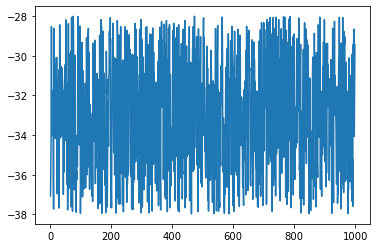

In [99]:
import matplotlib.pyplot as plt
import numpy as np

x = [x for x in range(1,1000)]
x = np.array(x)
y = np.array(y)
y = [1 for y in range(1, 1000)]
for i in range(len(y)):
    y[i] = y[i] * random.uniform(-38, -28)
plt.plot(x, y)

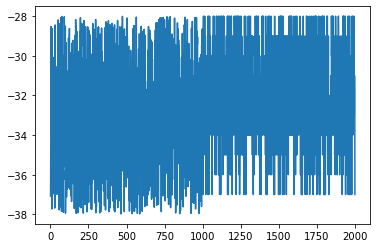

In [100]:
x2 = [x for x in range(1000, 2000)]
y2 = [1 for y in range(1000, 2000)]
x2 = np.array(x2)
y2 = np.array(y2)
for i in range(len(y2)):
    if np.random.rand(1,1) >= 0.5:
        y2[i] = y2[i] * random.uniform(-35, -28)
    else:
        y2[i] = y2[i] * random.uniform(-38, -28)
x = np.concatenate([x, x2])
y = np.concatenate([y, y2])
plt.plot(x, y)

In [62]:
x, y

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

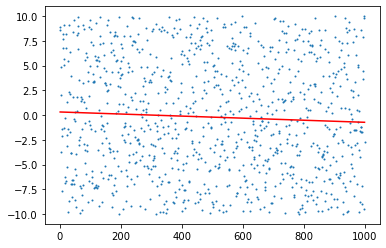

In [41]:
plt.scatter(x, y, s=1)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), 'r')

In [26]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.registration import register

register(
    id='FrozenLake-v3',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name':'4x4', 'is_slippery':False}
)
env = gym.make('FrozenLake-v3')

In [27]:
Q = np.zeros([env.observation_space.n, env.action_space.n])
Q.shape

(16, 4)

In [28]:
dis = 0.99
num_episodes=2000

rList=[]

In [30]:
alpha = 0.5
for i in range(num_episodes):
    state = env.reset()
    rAll = 0
    done = False
    
    e = 1./((i/100)+1)
    
    while not done:
        if np.random.rand() < e:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state, :])
        
        print(state)
        new_state, reward, done, _ = env.step(action)
        Q[state, action] = (1-alpha) * Q[state, action] + alpha * (reward + dis * np.max(Q[new_state, :]))
        rAll += reward
        state = new_state
    rList.append(rAll)

0
1
0
4
8
4
0
0
0
0
4
0
1
2
1
1
0
4
8
9
10
6
2
1
0
1
2
2
6
0
0
0
0
0
4
0
0
0
4
8
8
9
0
0
1
1
2
1
1
0
0
0
0
4
4
4
0
1
0
0
0
0
0
0
1
1
2
3
2
2
1
0
4
8
0
4
0
1
1
0
0
0
0
0
0
0
1
1
0
4
0
0
0
0
0
0
0
4
8
8
0
0
1
1
1
0
4
0
0
4
8
0
0
0
0
1
0
1
2
2
1
0
0
1
1
0
1
0
4
0
4
0
4
8
8
8
9
0
1
1
2
2
2
1
2
1
1
0
0
0
0
0
0
4
8
8
4
0
4
0
1
0
0
0
1
0
4
4
8
4
0
4
0
0
0
0
1
0
0
0
0
4
4
8
8
8
8
9
8
0
1
0
4
0
1
2
1
0
0
0
4
4
0
1
1
1
2
3
2
2
1
0
0
4
4
4
4
4
4
4
4
0
1
2
3
0
4
4
4
8
8
9
8
0
0
4
4
0
1
2
3
2
3
0
1
2
1
0
4
0
1
0
4
0
0
0
0
4
0
0
0
4
0
0
0
0
0
0
0
0
0
0
0
0
4
0
1
0
4
4
4
4
0
0
1
0
4
4
0
0
0
4
8
9
13
0
4
4
4
8
8
8
9
0
1
0
4
4
4
4
8
9
10
6
0
0
0
0
0
1
0
0
0
0
0
1
0
0
4
4
4
4
4
4
0
0
0
4
0
0
0
4
8
8
8
0
0
0
0
1
0
1
0
1
1
1
0
4
4
8
8
4
0
1
0
0
0
0
4
4
4
0
4
4
4
0
1
0
0
0
0
0
4
0
0
0
0
0
1
0
4
0
1
0
0
0
4
4
0
0
4
8
8
8
8
8
8
0
1
0
0
4
8
0
0
0
0
0
0
1
2
2
6
0
0
1
1
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
4
8
8
9
0
0
0
0
0
0
0
0
0
0
4
8
8
8
8
9
10
14
14
0
0
0
4
4
0
0
1
0
0
0
4
4
4
4
4
0
4
0
0
0
1
0
1
2
1
0
1
0
0
0
0


0
4
8
9
13
14
0
0
4
8
9
13
14
0
4
8
9
13
14
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
0
4
8
9
13
14
0
4
8
9
13
14
0
0
0
4
8
9
13
14
0
4
8
9
13
14
0
4
0
4
8
9
13
14
13
14
0
4
8
9
13
14
0
0
4
8
9
13
13
14
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
9
13
14
0
0
4
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
8
9
13
14
0
4
8
9
13
14
14
0
4
8
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
14
0
4
8
9
8
9
13
14
13
14
0
4
8
9
13
14
0
4
8
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
0
0
4
8
9
13
14
0
0
4
8
8
9
13
14
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
0
4
0
4
8
9
0
4
8
9
13
14
13
13
14
0
4
8
9
13
0
4
8
9
13
14
13
14
0
4
8
9
13
14
0
4
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
10
9
13
14
0
4
8
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
0
4
8
9
13
14
13
14
0
4
8

0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
0
4
8
9
13
9
13
14
0
4
8
9
13
14
0
4
8
9
10
9
13
13
14
0
0
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
10
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
8
9
13
14
0
4
8
0
4
8
9
13
14
0
4
0
4
8
9
13
14
0
1
0
4
8
9
13
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
10
9
13
14
0
4
0
4
8
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
0
4
8
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
8
0
0
4
8
9
13
14
0
4
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0
0
4
8
9
13
14
0
0
4
8
9
13
14
0
4
0
4
8
9
13
14
0
4
8
9
13
14
0
4
8
9
13
14
0

In [18]:
similarity = 0
for layout in layout_db_list:
    sim = calculate_similarity(input_layout, layout)
    if sim > similarity:
        similarity = sim
        target_layout = layout

NameError: name 'layout_db_list' is not defined

In [116]:
from sklearn.preprocessing import OneHotEncoder
x = [x for x in range(16)]
#x = np.array(x).reshape(-1, 1)
enc = OneHotEncoder()
enc.fit(x)

ValueError: Expected 2D array, got 1D array instead:
array=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [115]:
enc.categories_

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])]

In [ ]:
def get_furniture_size(furniture):
    return furniture['size']

def state_to_2D_grid(state):
    
def get_masking_grid(state, masking_grid, current_furniture):
    for i in range(len(state)):
        for j in range(len(state[i])):
            if state[i] != 0: masking_grid[i][j] = 1
                
    f_x, f_y = get_furniture_size(current_furniture)
    for i in range(len(masking_grid)):
        for j in range(len(masking_grid[i])):
            if masking_grid[i][j] == 1: continue
                
            if i + f_y >= max_y or j + f_x >= max_x:
                masking_grid[i][j] = 1
                
    return masking_grid

def get_action_space(masking_grid):
    action_list = []
    for i in range(len(masking_grid)):
        for j in range(len(masking_grid[i])):
            if masking_grid[i][j] == 0:
                action_list.append((i, j))
                
def action_next_state(state, action_space, current_furniture):
    next_state_list = []
    f_x, f_y = get_furniture_size(current_furniture)
    for action in action_space:
        next_state = state.copy()
        for i in range(action[0], f_y + 1):
            for j in range(action[1], f_x + 1):
                next_state[i][j] = current_furniture['num']
        next_state_list.append(next_state)
        
    return next_state_list

In [ ]:
categories_entropy = d_intro(furniture, furniture_copy, x_copy)
next_state_list = state_to_2D_grid(raw_input(x_g_))
p = p_interval(categories_entropy, next_state_list)

In [19]:
state = np.zeros((20,20))
#next_state = np.zeros((20,20))
masking_grid = np.zeros((20,20))
target_layout = np.zeros((20,20))
size_grid = np.zeros((20,20))

In [ ]:
for furniture in input_layout_furniture_list:
    state = state_to_2D_grid(state)
    masking_grid = get_masking_grid(state, masking_grid)
    action_space = get_action_space(masking_grid)
    next_state_list = action_next_state(state, action_space)
    target_layout = target_layout_to_2D_grid(target_layout)
    size_grid = furniutre_size_to_2D_grid(furniture)
    
    input_data = [(state, next_state, masking_grid, target_layout, size_grid) for next_state in next_state_list]
    action = agent.get_action(input_data)
    
    state = next_state_list[action]
    
    r1 = get_reward_1(state)
    r2 = get_reward_2(state)
    r = (1-agent.beta) * r1 + agent.beta * r2
    
    agent.append_sample(state, masking_grid, next_state, target_layout, size_grid)

In [ ]:
agent.append_result = get_attribut(setter_ac)

In [7]:
sum(rList) / num_episodes

0.827

In [15]:
sum(rList) / num_episodes

0.832

In [8]:
Q

array([[0.94148015, 0.95099005, 0.93206535, 0.94148015],
       [0.94148015, 0.        , 0.92274469, 0.93206535],
       [0.93206535, 0.        , 0.        , 0.        ],
       [0.92274469, 0.        , 0.        , 0.        ],
       [0.95099005, 0.96059601, 0.        , 0.94148015],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.96059601, 0.        , 0.970299  , 0.95099005],
       [0.96059601, 0.9801    , 0.9801    , 0.        ],
       [0.970299  , 0.99      , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9801    , 0.99      , 0.970299  ],
       [0.9801    , 0.99      , 1.        , 0.9801    ],
       [0.        , 0.        , 0.        , 0.        ]])

In [16]:
Q

array([[0.94148015, 0.95099005, 0.95099005, 0.94148015],
       [0.94148015, 0.        , 0.96059601, 0.9483281 ],
       [0.94933538, 0.970299  , 0.94262102, 0.94069274],
       [0.95929562, 0.        , 0.45675862, 0.45675862],
       [0.95099005, 0.96059601, 0.        , 0.94148015],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9801    , 0.        , 0.93671494],
       [0.        , 0.        , 0.        , 0.        ],
       [0.96059601, 0.        , 0.970299  , 0.95099005],
       [0.96059601, 0.9801    , 0.9801    , 0.        ],
       [0.970299  , 0.99      , 0.        , 0.97019224],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9801    , 0.99      , 0.970299  ],
       [0.9801    , 0.99      , 1.        , 0.9801    ],
       [0.        , 0.        , 0.        , 0.        ]])

<BarContainer object of 2000 artists>

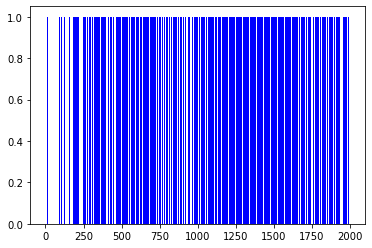

In [9]:
plt.bar(range(len(rList)), rList, color='blue')

<BarContainer object of 2000 artists>

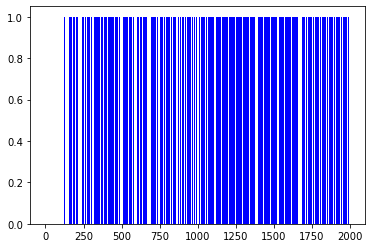

In [17]:
plt.bar(range(len(rList)), rList, color='blue')